# Tokens, Word Embeddings & Language Representation

## Learning Objectives:
- Understand what tokens are.
- Learn how to tokenize text using the Hugging Face Transformers library.
- Explore what embeddings are, their role in representing meaning, and how to extract them from a pretrained neural network model.
- Work with a real dataset to see these ideas in action.

## Tokens and Tokenization

In Natural Language Processing (NLP), **tokens** are the basic units into which text is split. They can be words, subwords, or characters. Tokenization is essential because:
- **Standardization:** It converts raw text into a standardized form.
- **Input for Models:** Neural networks process fixed units (tokens), not raw text.
- **Handling Vocabulary:** It helps in building a vocabulary and managing out-of-vocabulary words.

Below, we will see how to tokenize text using a pretrained tokenizer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.nn.functional import cosine_similarity

from datasets import load_dataset

# Load a pretrained tokenizer (we'll use 'bert-base-uncased' as an example).
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Example text for tokenization
example_text = "Generative AI is transforming the way we work with data."

# Tokenize the text
tokens = tokenizer.tokenize(example_text)
token_ids = tokenizer(example_text)["input_ids"]

print("Original Text:\n", example_text)
print("\nTokens:\n", tokens)
print("\nToken IDs:\n", token_ids)
print("\nDecoded Text:\n", tokenizer.decode(token_ids))

Original Text:
 Generative AI is transforming the way we work with data.

Tokens:
 ['genera', '##tive', 'ai', 'is', 'transforming', 'the', 'way', 'we', 'work', 'with', 'data', '.']

Token IDs:
 [101, 11416, 6024, 9932, 2003, 17903, 1996, 2126, 2057, 2147, 2007, 2951, 1012, 102]

Decoded Text:
 [CLS] generative ai is transforming the way we work with data. [SEP]


### Main Tasks of a Tokenizer

Tokenizers can be thought of as **lookup tables** that map text to numerical representations, enabling models to process and understand language.

1. **Tokenization**: Splits text into tokens (e.g., words, subwords, or characters).
2. **Token-to-ID Mapping**: Converts tokens into numerical IDs.
3. **Special Tokens**: Adds tokens like `[CLS]` or `[SEP]` for specific models.
4. **OOV Handling**: Replaces unknown words with `[UNK]`.
5. **Padding/Truncation**: Adjusts sequence lengths with `[PAD]` or truncates.
6. **Attention Masks**: Marks real tokens vs. padding (e.g., `[1, 1, 0, 0]`).


In [2]:
# Display the vocabulary
vocabulary = tokenizer.vocab

# Convert the vocabulary dictionary to a DataFrame
vocab_df = pd.DataFrame(list(vocabulary.items()), columns=["Token", "Index"])

# Display the first 20 tokens in a tabular format
print("Vocabulary Size:", len(vocabulary))
print("\nSample Vocabulary:")
vocab_df.head(10)


Vocabulary Size: 30522

Sample Vocabulary:


,Token,Index
0,jalan,28410
1,paradox,20506
2,jammu,21433
3,##rates,20370
4,evangelical,11295
5,sculptors,28417
6,##drome,29171
7,buren,29470
8,remembers,17749
9,nations,3741


### Working with a Real Dataset

For practical learning, we use a real dataset from Hugging Face. In this notebook, we load a small subset of the IMDb dataset, which is widely used for NLP tasks.


In [3]:
# Load a small subset of the IMDb dataset
dataset = load_dataset("imdb", split="train[:1000]")

# Inspect a sample review
sample_review = dataset[0]["text"]
print("Sample Review:\n", sample_review[:500], "...\n")


Sample Review:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent ...



We can tokenize the entire dataset efficiently in batches.

In [4]:
# Tokenize the dataset
tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)

# Inspect the tokenized dataset
print(tokenized_dataset)

# Convert the tokenized dataset to a pandas DataFrame
tokenized_df = tokenized_dataset.to_pandas()[["text", "input_ids"]]

# Display the DataFrame
tokenized_df.head()

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


,text,input_ids
0,I rented I AM CURIOUS-YELLOW from my video sto...,"[101, 1045, 12524, 1045, 2572, 8025, 1011, 375..."
1,"""I Am Curious: Yellow"" is a risible and preten...","[101, 1000, 1045, 2572, 8025, 1024, 3756, 1000..."
2,If only to avoid making this type of film in t...,"[101, 2065, 2069, 2000, 4468, 2437, 2023, 2828..."
3,This film was probably inspired by Godard's Ma...,"[101, 2023, 2143, 2001, 2763, 4427, 2011, 2643..."
4,"Oh, brother...after hearing about this ridicul...","[101, 2821, 1010, 2567, 1012, 1012, 1012, 2044..."


## Word Embeddings

### What are Embeddings?
Embeddings are dense vector representations of tokens. They capture semantic information about words, meaning that words with similar meanings will have similar embeddings. In modern NLP, embeddings are learned using neural networks, which allow models to understand context and nuance.

### Why Are They Important?
- **Semantic Similarity:** Embeddings help in measuring similarity between words.
- **Downstream Tasks:** They serve as inputs to models for tasks like classification, translation, and text generation.
- **Transfer Learning:** Pretrained embeddings can be used as a starting point for various NLP applications.

Below, we will use a pretrained transformer model to extract learned embeddings.

In [5]:
# Load a pretrained transformer model (BERT) to extract embeddings.
# Note: The model returns contextual embeddings that adjust based on the input sentence.
model = AutoModel.from_pretrained("bert-base-uncased")

# Encode the example text to get embeddings.
# The tokenizer converts the text to input IDs and attention masks.
inputs = tokenizer(example_text, return_tensors="pt")
outputs = model(**inputs)

# Extract embeddings for all tokens
# Here, we take the last hidden state (batch_size, sequence_length, hidden_size)
embeddings = outputs.last_hidden_state

print("Shape of embeddings:", embeddings.shape)


Shape of embeddings: torch.Size([1, 14, 768])


### Token Embedding Exploration

Let's examine the embeddings of a few tokens from our example. We will look at the embeddings for a subset of tokens and visualize their values (truncated for brevity).

In [6]:
# Convert the embeddings tensor to a NumPy array for easier handling.
embeddings_np = embeddings.detach().numpy()

# Get token strings from the tokenizer output
tokenized_example = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print("Tokens with their embeddings (first 5 dimensions):\n")
for token, emb in zip(tokenized_example, embeddings_np[0]):
    print(f"{token:12s}: {emb[:5]}")


Tokens with their embeddings (first 5 dimensions):

[CLS]       : [-0.11637579 -0.02889033 -0.26962504 -0.1374814  -0.49918202]
genera      : [-0.43408194  0.42262033 -0.06637587  0.21109392  0.02033129]
##tive      : [-0.9221342   0.08395163  0.27106875  0.38471085  0.5143331 ]
ai          : [0.0743405  0.518764   0.3018257  0.18460913 0.8921068 ]
is          : [-0.13791838  0.51696163 -0.40058678 -0.45129475  0.1828306 ]
transforming: [-0.1145344  -0.35881957  0.01241033  0.17634293  0.23852278]
the         : [-0.16604848 -0.01644552  0.00692202 -0.07304969  0.35772654]
way         : [0.47490337 0.5972781  0.26706654 0.27936172 0.22679976]
we          : [ 0.61885333  0.48982242 -0.17001584  0.48642236 -0.34666288]
work        : [ 0.26317054  0.9425098  -0.45817497 -0.23169859  0.6479079 ]
with        : [ 0.06112781  0.4268403   0.12077139  0.22314745 -0.16226739]
data        : [ 0.3544978  -0.25741586  0.09655534  0.48360664  1.2270073 ]
.           : [ 0.5529192   0.11830389 -0.3576

### Embedding Arithmetic with Static Token Embeddings

Contextual embeddings vary by sentence, so for arithmetic we use the static token embeddings from BERT’s input embedding layer. These embeddings—learned during pretraining—provide a fixed representation for each token.


#### Measuring Similarity Between Words (Cosine Similarity)

In [7]:
# Get embeddings for selected words (use tokens without subword prefixes)
tokens = ["good", "great", "bad", "terrible"]
token_ids = tokenizer(tokens, return_tensors="pt", add_special_tokens=False)["input_ids"]

# Get embeddings from model
with torch.no_grad():
    word_outputs = model(**tokenizer(tokens, return_tensors="pt", add_special_tokens=False))
    word_embeddings = word_outputs.last_hidden_state.mean(dim=1)  # use average across tokens

# Compute pairwise cosine similarity
similarities = cosine_similarity(word_embeddings.unsqueeze(1), word_embeddings.unsqueeze(0), dim=-1)

# Display as a matrix
sim_df = pd.DataFrame(similarities.numpy(), index=tokens, columns=tokens)
sim_df.style.background_gradient(cmap="Blues")


,good,great,bad,terrible
good,1.000000,0.661057,0.534841,0.212155
great,0.661057,1.000000,0.454080,0.194178
bad,0.534841,0.454080,1.000000,0.298262
terrible,0.212155,0.194178,0.298262,1.000000


#### Finding a "Semantic Direction"
We can perform simple arithmetic, for example:
- **king - man + woman ≈ ?**

We extract the static embeddings and then search for the nearest token to the computed vector.

In [8]:
# Get the static token embeddings from the model's input embeddings
static_embeddings = model.get_input_embeddings().weight.detach().numpy()

# Function to get the embedding of a token from the static embeddings
def get_token_embedding(token, tokenizer, static_embeddings):
    token_id = tokenizer.convert_tokens_to_ids(token)
    return static_embeddings[token_id]

# Perform arithmetic: king - man + woman
king_emb = get_token_embedding("king", tokenizer, static_embeddings)
man_emb = get_token_embedding("man", tokenizer, static_embeddings)
woman_emb = get_token_embedding("woman", tokenizer, static_embeddings)

# Compute the resulting vector
result_vector = king_emb - 2 * man_emb + 2 * woman_emb

# Function to compute cosine similarity between two vectors
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Find the top 5 closest tokens in the vocabulary to the result_vector
all_tokens = list(tokenizer.get_vocab().keys())
similarities = {}
for tok in all_tokens:
    # Get token embedding
    try:
        tok_emb = get_token_embedding(tok, tokenizer, static_embeddings)
        sim = cosine_similarity(result_vector, tok_emb)
        similarities[tok] = sim
    except Exception as e:
        continue

# Sort tokens by similarity score in descending order
sorted_similar_tokens = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

print("Top 10 tokens similar to (king - man + woman):")
for tok, score in sorted_similar_tokens[:10]:
    print(f"{tok}: {score:.4f}")


Top 10 tokens similar to (king - man + woman):
queen: 0.5128
woman: 0.4967
female: 0.4522
king: 0.4440
women: 0.4369
females: 0.4037
princess: 0.4030
queens: 0.3894
empress: 0.3850
duchess: 0.3841


### Clustering Tokens from the Static Embedding Space

We can also pick a set of semantically related tokens and visualize their static embeddings. For instance, consider tokens related to royalty and common adjectives.


In [9]:
def visualize_embeddings(embeddings_arr, tokens_list, method="pca"):
    """
    Visualizes token embeddings using PCA or t-SNE.
    
    Parameters:
    - embeddings_arr: numpy array of shape (n_tokens, embedding_dim)
    - tokens_list: list of token strings corresponding to the embeddings
    - method: "pca" or "tsne"
    """
    if method == "pca":
        reduced = PCA(n_components=2).fit_transform(embeddings_arr)
        title = "PCA"
    elif method == "tsne":
        reduced = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(embeddings_arr)
        title = "t-SNE"
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1])
    for i, token in enumerate(tokens_list):
        plt.text(reduced[i, 0] + 0.01, reduced[i, 1] + 0.01, token, fontsize=10)
    plt.title(f"Token Embeddings Visualized with {title}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()



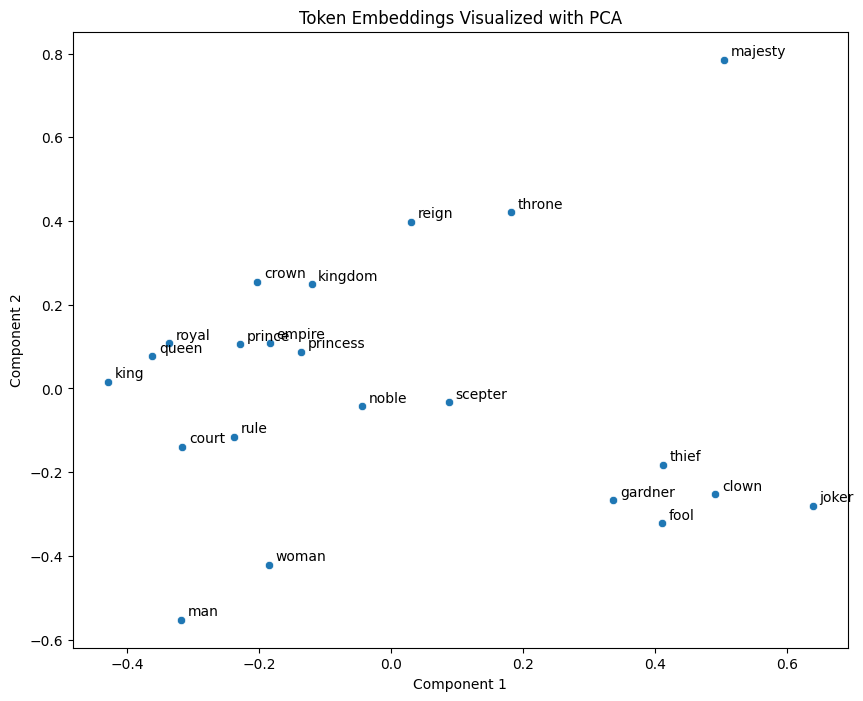

In [10]:
# Define a set of tokens of interest
selected_tokens = ["king", "queen", "prince", "princess", "man", "woman", "royal", "noble", "throne", "crown", "joker", "clown", "fool", "court", "kingdom", "empire", "reign", "rule", "scepter", "majesty", "thief", "gardner"]

# Get embeddings for these tokens
selected_embeddings = []
for token in selected_tokens:
    try:
        emb = get_token_embedding(token, tokenizer, static_embeddings)
        selected_embeddings.append(emb)
    except Exception as e:
        print(f"Token {token} not found.")
selected_embeddings = np.array(selected_embeddings)

# Visualize these tokens using PCA
visualize_embeddings(selected_embeddings, selected_tokens, method='pca')


## Summary and Next Steps

In this notebook, we have:
- Introduced tokens and explained their role in NLP.
- Tokenized text using the Hugging Face Transformers library.
- Explained the concept of embeddings and their importance.
- Loaded a real dataset (IMDb) for contextual learning.
- Extracted learned embeddings from a pretrained BERT model.

These foundational concepts and practical tools will support the rest of the course as we explore more advanced language models and generative techniques.